## Introduction

In this notebook, we attempt to predict whether trading the stock index mentioned in a tweet will yield a return greater than 1%, given the popularity, sentiment scores and other features related to the tweet. We assume that we enter into a long position in the stock index at a fixed time, $t_1$, after the tweet, and we similarly sell off the index at a later fixed time, $t_2$. These $t_1$ and $t_2$ are generally treated as hyperparameters and <b> not as features. </b>

We will use 2 Bayesian-based classifiers in this notebook: Naive Bayes Classifier and quadratic discriminant analysis (QDA).




## Naive Bayes Classifier

Recall that the Naive Bayes Model assumes that the likelihood distribution, $P(X_j|y=c)$, for each class $c$ and feature $j$ is independent. To adhere to this central assumption for the model, we will only include features that are not strongly correlated to one another. 

We begin by downloading the data and performing the train-test split. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_parquet("/Users/josht/Documents/tweet_stock_merged_data1.parquet")

In [3]:
df.sample(5)

,time_stamp,entities_cashtags,entities_hashtags,entities_urls,like_count,quote_count,reply_count,retweet_count,text,entities_mentions,...,Company_ticker,time_of_day,morning,evening,night,buy_price,delta_buy,sell_price,delta_sell,return
5744,2021-05-23 11:22:35,1,3,1,1,0,0,0,$VBK - Vanguard Small Cap Growth ETF: Low-Risk...,0,...,LOW,morning,0,1,0,191.024326,74305.0,192.115894,331345.0,0.571429
64193,2020-09-15 07:57:07,0,0,0,264,5,15,22,"I want my opinions to be about charts, not mar...",0,...,SO,morning,0,1,0,51.003184,5633.0,50.686334,302333.0,-0.621235
30872,2021-06-05 12:49:46,0,0,1,15,0,11,1,I live in Seattle but the city is becoming a p...,0,...,FAST,morning,0,1,0,52.714206,151874.0,52.516218,331454.0,-0.375587
46629,2021-02-25 18:11:28,0,0,1,3,0,1,0,But boiling it will make me sick? https://t.co...,0,...,TWTR,night,0,0,1,74.400000,32.0,78.850000,300092.0,5.981183
59205,2020-04-19 21:33:14,0,0,0,262,2,22,39,"For a while, investors have had to drink from ...",0,...,A,night,0,0,1,78.351773,39706.0,75.657502,300106.0,-3.438685


In [4]:
df.columns

Index(['time_stamp', 'entities_cashtags', 'entities_hashtags', 'entities_urls',
       'like_count', 'quote_count', 'reply_count', 'retweet_count', 'text',
       'entities_mentions', 'created_at_user', 'followers_count',
       'following_count', 'listed_count', 'tweet_count', 'media_type',
       'Company_name', 'Word_count_News_agencies', 'Word_count_Henry08_pos',
       'Word_count_Henry08_neg', 'Word_count_LM11_pos', 'Word_count_LM11_neg',
       'Word_count_Hagenau13_pos', 'Word_count_Hagenau13_neg',
       'Tweet_Length_characters', 'Tweet_Length_words', 'Compound_vader',
       'Positive_vader', 'Negative_vader', 'Neutral_vader', 'Company_ticker',
       'time_of_day', 'morning', 'evening', 'night', 'buy_price', 'delta_buy',
       'sell_price', 'delta_sell', 'return'],
      dtype='object')

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.2, shuffle = True)

In [6]:
df.shape

(724283, 40)

In [7]:
df_train.shape

(579426, 40)

In [8]:
df_test.shape

(144857, 40)

These are the potential features we will use in our model. The last three are categorical and result from onehot encoding. We will drop the last one to avoid redundancy. 

In [9]:
potential_features = ['like_count', 'quote_count', 'reply_count', 'retweet_count', 'followers_count', 
                      'following_count', 'listed_count', 'tweet_count', 'Word_count_News_agencies', 
                      'Word_count_Henry08_pos', 'Word_count_Henry08_neg', 'Word_count_LM11_pos', 
                      'Word_count_LM11_neg', 'Word_count_Hagenau13_pos', 'Word_count_Hagenau13_neg', 
                      'Tweet_Length_characters', 'Tweet_Length_words', 'Compound_vader', 'Positive_vader', 
                      'Negative_vader', 'Neutral_vader', 'morning', 'evening', 'night']

Now, we employ PCA to select uncorrelated quantitative features.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA()

In [11]:
X_quant_train = np.array(df_train[potential_features[:-3]])

In [12]:
X_qt_st = scaler.fit_transform(X_quant_train)
phi_train = pca.fit_transform(X_qt_st)

In [13]:
phi_train.shape

(579426, 21)

In [14]:
print(100 * pca.explained_variance_ratio_)

[1.40831257e+01 1.31820477e+01 1.16883652e+01 1.06266879e+01
 8.95287041e+00 5.50897355e+00 5.05975678e+00 4.43713362e+00
 4.18882947e+00 3.91243113e+00 3.71412709e+00 3.22245624e+00
 2.67193144e+00 2.59443256e+00 2.40971384e+00 2.37384733e+00
 4.50498647e-01 4.42380810e-01 2.69090215e-01 2.11292137e-01
 8.19096753e-06]


Let us get rid of the last five features, as they contribute little to the total variance. Since we centered and scaled the data before applying PCA, the resulting principal components are uncorrelated to one another.

In [15]:
X_train = np.concatenate((phi_train[:, :-5], np.array(df_train[['morning', 'evening']])), axis=1)

In [16]:
np.shape(X_train)

(579426, 18)

In [17]:
phi_test = pca.fit_transform(scaler.fit_transform(np.array(df_test[potential_features[:-3]])))
X_test = np.concatenate((phi_test[:, :-5], np.array(df_test[['morning', 'evening']])), axis=1)

In [18]:
np.shape(X_test)

(144857, 18)

In [19]:
y_train = np.array(df_train["return"] >= 1.0)
y_test = np.array(df_test["return"] >= 1.0)

Now, we are ready to train our Naive Bayes Classifier on the training set.

In [20]:
from sklearn.naive_bayes import GaussianNB

In [21]:
NB = GaussianNB()

NB.fit(X_train, y_train)

GaussianNB()

In [22]:
pred_train = NB.predict(X_train)

In [23]:
acc_train = sum(pred_train == y_train)/y_train.shape[0]
print("Training accuracy:", acc_train)

Training accuracy: 0.621891320030513


In [24]:
pred_test = NB.predict(X_test)
acc_test = sum(pred_test == y_test)/y_test.shape[0]
print("Test accuracy:", acc_test)

Test accuracy: 0.6297935205064304


In [25]:
from sklearn.metrics import roc_auc_score

auc_train = roc_auc_score(y_train, pred_train)
print("Training ROC AUC:", auc_train)

auc_test = roc_auc_score(y_test, pred_test)
print("Test ROC AUC:", auc_test)

Training ROC AUC: 0.5009707613519674
Test ROC AUC: 0.5004476878587101


:(

## Quadratic Discriminant Analysis

QDA assumes that the joint likelihood distribution for each class $c$ is a multivariate normal distribution: $P(X_1,\ldots,X_m|y=c) \sim \mathcal{N}(\mu_c, \Sigma_c)$. In order to closely approximate the model assumption, we will take the logarithm of some of the features whose distributions are highly skewed to the right.

Then, the natural starting point is to look at the histogram of all quantitative features.

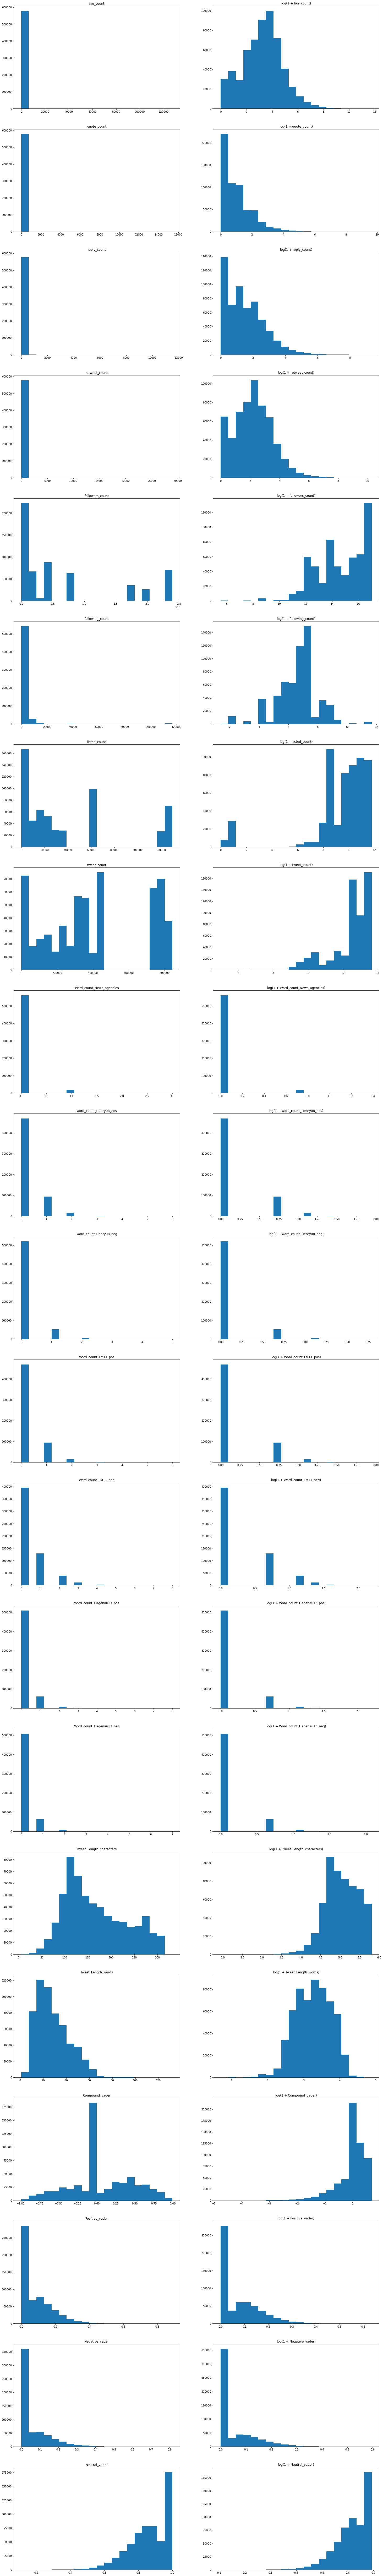

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(potential_features)-3, 2, figsize=(25,180))

for i in range(len(potential_features)-3):
    ax[i, 0].hist(df_train[potential_features[i]], bins=20)
    ax[i, 0].set_title(potential_features[i])
    ax[i, 1].hist(np.log(1 + df_train[potential_features[i]]), bins=20)
    ax[i, 1].set_title("log(1 + "+potential_features[i]+")")

It is unfortunately the case for a lot of features that neither its logarithm nor the feature itself is normally distributed. However, we will do the best we can. The features whose distribution become closer to normal distribution once one takes the logarithm are listed below. 

In [27]:
features_log = ['like_count', 'quote_count', 'reply_count', 'retweet_count', 'following_count', 
                'Tweet_Length_characters', 'Tweet_Length_words']
features_non_log = [x for x in potential_features[:-1] if x not in features_log]

In [28]:
X_train2 = np.concatenate((np.array(np.log(1 + df_train[features_log])), 
                          np.array(df_train[features_non_log])), axis=1)
X_test2 = np.concatenate((np.array(np.log(1 + df_test[features_log])), 
                          np.array(df_test[features_non_log])), axis=1)

In [29]:
y_train2 = np.array(df_train["return"] >= 1.0)
y_test2 = np.array(df_test["return"] >= 1.0)

In [30]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

QDA = QuadraticDiscriminantAnalysis()

In [31]:
QDA.fit(X_train2, y_train2)

QuadraticDiscriminantAnalysis()

In [32]:
pred_train2 = QDA.predict(X_train2)
acc_train2 = sum(pred_train2 == y_train2)/y_train2.shape[0]
print("Training accuracy:", acc_train2)

pred_test2 = QDA.predict(X_test2)
acc_test2 = sum(pred_test2 == y_test2)/y_test2.shape[0]
print("Test accuracy:", acc_test2)

Training accuracy: 0.623606810878352
Test accuracy: 0.6231870051153897


In [33]:
auc_train2 = roc_auc_score(y_train2, pred_train2)
print("Training ROC AUC:", auc_train2)

auc_test2 = roc_auc_score(y_test2, pred_test2)
print("Test ROC AUC:", auc_test2)

Training ROC AUC: 0.5029782947226997
Test ROC AUC: 0.5023297651683494


The model performs better than the Naive Bayes model, but the AUC score is still very close to 0.50, indicating the noisy nature of the stock data.

## Tweet Filtering

The models do not perform very well when we use all the tweets. We will attempt to fit each model on popular tweets only. First, we will only use tweets with at least 20 retweets. Afterward, we will use tweets predicted by the popularity model to be popular.

### Threshold 1: At least 20 retweets

Let's start with the Naive Bayes Model.

In [34]:
df_train.loc[df_train["retweet_count"] >= 20].shape[0] / df_train["retweet_count"].shape[0]

0.2572373348796913

In [35]:
X11_train_qt = np.array(df_train.loc[df_train["retweet_count"] >= 20][potential_features[:-3]])
X11_test_qt = np.array(df_test.loc[df_test["retweet_count"] >= 20][potential_features[:-3]])
y11_train = np.array(df_train.loc[df_train["retweet_count"] >= 20]["return"] >= 1.0)
y11_test = np.array(df_test.loc[df_test["retweet_count"] >= 20]["return"] >= 1.0)

In [36]:
scaler11 = StandardScaler()
pca11 = PCA()

X11_train_int = scaler11.fit_transform(X11_train_qt)
X11_train_pca = pca11.fit_transform(X11_train_int)

In [37]:
X11_train = np.concatenate((X11_train_pca, np.array(df_train.loc[df_train["retweet_count"] >= 20][['morning', 'evening']])), axis=1)
X11_test_pca = PCA().fit_transform(StandardScaler().fit_transform(X11_test_qt))
X11_test = np.concatenate((X11_test_pca, np.array(df_test.loc[df_test["retweet_count"] >= 20][['morning', 'evening']])), axis=1)


In [38]:
NB11 = GaussianNB()

NB11.fit(X11_train, y11_train)

GaussianNB()

In [39]:
pred11_train = NB11.predict(X11_train)
acc11_train = sum(pred11_train == y11_train)/y11_train.shape[0]
print("Training accuracy:", acc11_train)

pred11_test = NB11.predict(X11_test)
acc11_test = sum(pred11_test == y11_test)/y11_test.shape[0]
print("Test accuracy:", acc11_test)

Training accuracy: 0.6171620261657162
Test accuracy: 0.6245601037229116


In [40]:
from sklearn.metrics import roc_auc_score

auc11_train = roc_auc_score(y11_train, pred11_train)
print("Training ROC AUC:", auc11_train)

auc11_test = roc_auc_score(y11_test, pred11_test)
print("Test ROC AUC:", auc11_test)

Training ROC AUC: 0.5028603348964648
Test ROC AUC: 0.5015295959741529


This version of Naive Bayes performs significantly better than Naive Bayes trained on all the tweets, with the AUC score comparable to QDA trained on all the tweets.

Now, let's train a QDA model on the data with at least 20 retweets.

In [41]:
X12_train = np.concatenate((np.array(np.log(1 + df_train.loc[df_train["retweet_count"] >= 20][features_log])),
                            np.array(df_train.loc[df_train["retweet_count"] >= 20][features_non_log])), axis=1)
X12_test = np.concatenate((np.array(np.log(1 + df_test.loc[df_test["retweet_count"] >= 20][features_log])),
                           np.array(df_test.loc[df_test["retweet_count"] >= 20][features_non_log])), axis=1)

In [42]:
y12_train = y11_train
y12_test = y11_test

In [43]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

QDA12 = QuadraticDiscriminantAnalysis()
QDA12.fit(X12_train, y12_train)

QuadraticDiscriminantAnalysis()

In [44]:
pred12_train = QDA12.predict(X11_train)
acc12_train = sum(pred12_train == y12_train)/y12_train.shape[0]
print("Training accuracy:", acc12_train)

pred12_test = QDA12.predict(X11_test)
acc12_test = sum(pred12_test == y12_test)/y12_test.shape[0]
print("Test accuracy:", acc12_test)

Training accuracy: 0.6239852398523985
Test accuracy: 0.6278146746752044


In [45]:
auc12_train = roc_auc_score(y12_train, pred12_train)
print("Training ROC AUC:", auc12_train)

auc12_test = roc_auc_score(y12_test, pred12_test)
print("Test ROC AUC:", auc12_test)

Training ROC AUC: 0.500015786340432
Test ROC AUC: 0.500100016988087


Surprisingly, training QDA on tweets with at least 20 retweets do not result in a good performance.

### Threshold 2: Popular Tweets according to the Tweet Model

Let us begin by loading the model.

In [50]:
import pickle

popularity_scaler = pickle.load(open("/Users/josht/Documents/GitHub/erdos_twitter_project/ML_models/Tweet_Prediction/lgbm_scaler.pickle", 'rb'))
popularity_model = pickle.load(open("/Users/josht/Documents/GitHub/erdos_twitter_project/ML_models/Tweet_Prediction/lgbm_model.pickle", 'rb'))


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [ ]:
popularity_scaler()